In [119]:
import torch
import torchvision.transforms as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from scipy.interpolate import griddata
import os
import pandas as pd

# MiDas

In [120]:
# Load the MiDaS model
model_type = "DPT_Large"  # or "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Load transforms to prepare input images for the model
transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform if "DPT" in model_type else torch.hub.load("intel-isl/MiDaS", "transforms").midas_transform

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

Using cache found in /Users/christiaanhildebrand/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/christiaanhildebrand/.cache/torch/hub/intel-isl_MiDaS_master


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

# Monodepth2

In [121]:
model = torch.hub.load("nianticlabs/monodepth2", "mono+stereo_1024x320", pretrained=True)
model.eval()

Using cache found in /Users/christiaanhildebrand/.cache/torch/hub/nianticlabs_monodepth2_master


FileNotFoundError: [Errno 2] No such file or directory: '/Users/christiaanhildebrand/.cache/torch/hub/nianticlabs_monodepth2_master/hubconf.py'

# LeRes

In [85]:
model = torch.hub.load("aim-uofa/AdelaiDepth", "LeReS", pretrained=True)
model.eval()

Downloading: "https://github.com/aim-uofa/AdelaiDepth/zipball/main" to /Users/christiaanhildebrand/.cache/torch/hub/main.zip


FileNotFoundError: [Errno 2] No such file or directory: '/Users/christiaanhildebrand/.cache/torch/hub/aim-uofa_AdelaiDepth_main/hubconf.py'

# LIDAR

In [ ]:
model = torch.hub.load("milesial/Pytorch-UNet", "unet_carvana", pretrained=True)
model.eval()

# FastDepth

In [ ]:
model = torch.hub.load("ravijo/fastdepth", "FastDepth")
model.eval()

# DepthNet

In [ ]:
model = torch.hub.load("isl-org/depth", "DepthNet", pretrained=True)
model.eval()

# Predicting the depth of a pothole

In [122]:
segmentation_model = YOLO('YOLO/Segmentation/best.pt')

In [ ]:
def estimate_depth(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    
    # Convert the image to a NumPy array
    image_np = np.array(image)
    
    # Apply the transform to the image
    input_batch = transform(image_np).to(device)
    
    # Ensure input_batch has the correct shape
    if len(input_batch.shape) == 3:
        input_batch = input_batch.unsqueeze(0)  # Add batch dimension

    # Perform depth estimation
    with torch.no_grad():
        prediction = model(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image_np.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

def compute_pothole_volume(image_path, segmentation_model, depth_model, transform, device):
    # Step 1: Load the image
    image = cv2.imread(image_path)
    
    # Step 2: Use the segmentation model to get the pothole mask
    contour_results = segmentation_model.predict(source=image, conf=0.01, save=False, verbose=False)

    if contour_results[0].masks is None:
        print("No pothole detected.")
        return None
    
    # Extract the mask with the highest confidence
    masks = contour_results[0].masks.data.cpu().numpy()
    mask_scores = contour_results[0].boxes.conf.cpu().numpy()
    max_conf_idx = np.argmax(mask_scores)
    best_mask = masks[max_conf_idx]

    # Apply threshold to mask
    mask = (best_mask > 0.5).astype(np.uint8) * 255

    # Ensure the mask is of the same size as the depth map and 8-bit
    mask = cv2.resize(mask, (image.shape[1], image.shape[0])).astype(np.uint8)

    # Step 3: Apply depth estimation on the entire image
    depth_map = estimate_depth(image_path, depth_model, transform, device)

    # Convert the depth map to the same dtype as the mask
    depth_map = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    # Step 4: Calculate the volume
    pothole_depth_map = cv2.bitwise_and(depth_map, depth_map, mask=mask)

    # Integrate depth over the segmented area to compute volume
    volume = np.sum(pothole_depth_map)  # Sum of depth values gives the volume in arbitrary units

    return volume, image, depth_map, mask

# Example usage
image_path = 'YOLO/Segmentation/original images/images/p1055.jpg'
pothole_volume, output_image, depth_map, mask = compute_pothole_volume(image_path, segmentation_model, midas, transform, device)

if pothole_volume is not None:
    print(f"Estimated Pothole Volume: {pothole_volume} arbitrary units")

    # Normalize depth map for better visualization
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Convert the output image to RGB for displaying
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Plot the image, mask, and depth map
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(output_image_rgb)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Pothole Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(depth_map_normalized, cmap='inferno')
    plt.title('Depth Map')

    plt.show()

# Interpolating the depth underneath the measuring stick

Estimated Pothole Volume: 7330420 arbitrary units


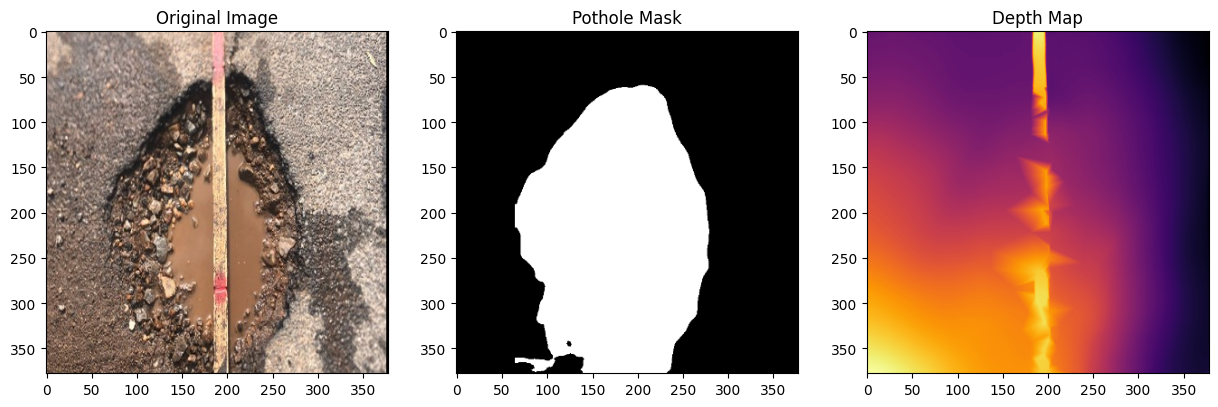

In [ ]:
def estimate_depth(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    
    # Convert the image to a NumPy array
    image_np = np.array(image)
    
    # Apply the transform to the image
    input_batch = transform(image_np).to(device)
    
    # Ensure input_batch has the correct shape
    if len(input_batch.shape) == 3:
        input_batch = input_batch.unsqueeze(0)  # Add batch dimension

    # Perform depth estimation
    with torch.no_grad():
        prediction = model(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image_np.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

def detect_and_mask_stick(image, mask, depth_map):
    # Convert image to HSV to detect the stick (assuming it's a wooden stick)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the color range for the stick (this range might need adjustment)
    lower_brown = np.array([10, 50, 50])
    upper_brown = np.array([30, 255, 255])
    
    stick_mask = cv2.inRange(hsv_image, lower_brown, upper_brown)
    
    # Combine the stick mask with the pothole mask to keep only the stick within the pothole area
    stick_mask = cv2.bitwise_and(stick_mask, mask)
    
    # Find the contours of the stick mask
    contours, _ = cv2.findContours(stick_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Create a masked depth map where the stick area is zeroed out
        depth_map_masked = cv2.bitwise_and(depth_map, depth_map, mask=cv2.bitwise_not(stick_mask))
        
        # Get the non-zero points from the masked depth map (valid depth points)
        y_coords, x_coords = np.nonzero(depth_map_masked)
        depth_values = depth_map_masked[y_coords, x_coords]
        
        # Generate a grid of all coordinates
        grid_x, grid_y = np.meshgrid(np.arange(depth_map.shape[1]), np.arange(depth_map.shape[0]))
        
        # Interpolate the depth values in the masked stick region
        interpolated_depth_map = griddata(
            (x_coords, y_coords),
            depth_values,
            (grid_x, grid_y),
            method='linear',
            fill_value=0
        )
        
        # Replace the stick area in the original depth map with the interpolated values
        depth_map[stick_mask > 0] = interpolated_depth_map[stick_mask > 0]
    
    return depth_map

def compute_pothole_volume(image_path, segmentation_model, depth_model, transform, device):
    # Step 1: Load the image
    image = cv2.imread(image_path)
    
    # Step 2: Use the segmentation model to get the pothole mask
    contour_results = segmentation_model.predict(source=image, conf=0.01, save=False, verbose=False)

    if contour_results[0].masks is None:
        print("No pothole detected.")
        return None
    
    # Extract the mask with the highest confidence
    masks = contour_results[0].masks.data.cpu().numpy()
    mask_scores = contour_results[0].boxes.conf.cpu().numpy()
    max_conf_idx = np.argmax(mask_scores)
    best_mask = masks[max_conf_idx]

    # Apply threshold to mask
    mask = (best_mask > 0.5).astype(np.uint8) * 255

    # Ensure the mask is of the same size as the depth map and 8-bit
    mask = cv2.resize(mask, (image.shape[1], image.shape[0])).astype(np.uint8)

    # Step 3: Apply depth estimation on the entire image
    depth_map = estimate_depth(image_path, depth_model, transform, device)

    # Detect and interpolate the stick area
    depth_map = detect_and_mask_stick(image, mask, depth_map)

    # Convert the depth map to the same dtype as the mask
    depth_map = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    # Step 4: Calculate the volume
    pothole_depth_map = cv2.bitwise_and(depth_map, depth_map, mask=mask)

    # Integrate depth over the segmented area to compute volume
    volume = np.sum(pothole_depth_map)  # Sum of depth values gives the volume in arbitrary units

    return volume, image, depth_map, mask

# Example usage
image_path = 'YOLO/Segmentation/original images/images/p1117.jpg'
pothole_volume, output_image, depth_map, mask = compute_pothole_volume(image_path, segmentation_model, midas, transform, device)

if pothole_volume is not None:
    print(f"Estimated Pothole Volume: {pothole_volume} arbitrary units")

    # Normalize depth map for better visualization
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Convert the output image to RGB for displaying
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Plot the image, mask, and depth map
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(output_image_rgb)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Pothole Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(depth_map_normalized, cmap='inferno')
    plt.title('Depth Map')

    plt.show()

# Creating a volume dataset

In [109]:
# Function to estimate depth
def estimate_depth(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    input_batch = transform(image_np).to(device)
    
    if len(input_batch.shape) == 3:
        input_batch = input_batch.unsqueeze(0)
    
    with torch.no_grad():
        prediction = model(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image_np.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

# Function to compute the volume of a pothole
def compute_pothole_volume(image_path, segmentation_model, depth_model, transform, device):
    image = cv2.imread(image_path)
    contour_results = segmentation_model.predict(source=image, conf=0.01, save=False, verbose=False)

    if contour_results[0].masks is None:
        return None
    
    masks = contour_results[0].masks.data.cpu().numpy()
    mask_scores = contour_results[0].boxes.conf.cpu().numpy()
    max_conf_idx = np.argmax(mask_scores)
    best_mask = masks[max_conf_idx]
    mask = (best_mask > 0.5).astype(np.uint8) * 255
    mask = cv2.resize(mask, (image.shape[1], image.shape[0])).astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  # Skip if no contours are found

    depth_map = estimate_depth(image_path, depth_model, transform, device)
    depth_map = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    total_volume = 0
    for contour in contours:
        # Create a mask for the current contour
        contour_mask = np.zeros_like(mask)
        cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)

        # Calculate the volume for the current contour
        pothole_depth_map = cv2.bitwise_and(depth_map, depth_map, mask=contour_mask)
        contour_volume = np.sum(pothole_depth_map)
        total_volume += contour_volume

    return total_volume

# Process images and store volumes
def process_images(image_dir, segmentation_model, depth_model, transform, device):
    volumes = []
    for image_name in os.listdir(image_dir):
        if image_name.endswith(('.jpg', '.png')):
            pothole_id = os.path.splitext(image_name)[0]
            image_path = os.path.join(image_dir, image_name)
            volume = compute_pothole_volume(image_path, segmentation_model, depth_model, transform, device)
            if volume is not None:
                volumes.append({'pothole_id': pothole_id, 'arbitrary_volume': volume})
    return pd.DataFrame(volumes)

# Assuming segmentation_model, depth_model, transform, and device are already initialized
train_image_dir = '../../../data/Patch Perfect Data/train_images'
test_image_dir = '../../../data/Patch Perfect Data/test_images'

train_volumes_df = process_images(train_image_dir, segmentation_model, midas, transform, device)
test_volumes_df = process_images(test_image_dir, segmentation_model, midas, transform, device)

# Save the results to CSV files
train_volumes_df.to_csv('data/train_pothole_volumes.csv', index=False)
test_volumes_df.to_csv('data/test_pothole_volumes.csv', index=False)

print("Volume estimation completed and saved.")

Volume estimation completed and saved.
